# Introduction

This notebook notains all code related to the final report in the course Social Graphs and Intercations (02805) and works as an explainer notebook to the handed in report.


# Package imports

In [21]:
import kagglehub
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
from networkx.algorithms.community import louvain_communities
from collections import Counter
import re
from collections import defaultdict
import requests
import zipfile
import os

# Data download and preprocessing

In [4]:
# Download latest version
path = kagglehub.dataset_download("harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows")
print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/imdb_top_1000.csv")

# Removing unnecessary columns
df = df.drop(columns=["Poster_Link", "Meta_score", "Certificate"])

print(df.info())

Path to dataset files: /Users/fridafrandsen/.cache/kagglehub/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows/versions/1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   1000 non-null   object 
 1   Released_Year  1000 non-null   object 
 2   Runtime        1000 non-null   object 
 3   Genre          1000 non-null   object 
 4   IMDB_Rating    1000 non-null   float64
 5   Overview       1000 non-null   object 
 6   Director       1000 non-null   object 
 7   Star1          1000 non-null   object 
 8   Star2          1000 non-null   object 
 9   Star3          1000 non-null   object 
 10  Star4          1000 non-null   object 
 11  No_of_Votes    1000 non-null   int64  
 12  Gross          831 non-null    object 
dtypes: float64(1), int64(1), object(11)
memory usage: 101.7+ KB
None


## Adding IMDB id using an API

There has been some problems with the use of our API keys, since there is a limit for how many requests can be made.
We have provided 4 different keys, so if one does not work, another can be used.
If none works, we have also provided a csv-file wherein the imdb-data has already been added.

In [8]:
API_KEY = "2aaf18d5"  
# API_KEY = "d8f1a797"  
# PI_KEY = "e61b1332"
# API_KEY = "a8c3078"
url = f"http://www.omdbapi.com/?apikey={API_KEY}&t=Inception"

def get_movie_info(title):
    url = "http://www.omdbapi.com/"
    params = {"t": title, "apikey": API_KEY}

    r = requests.get(url, params=params)
    print(title, r.status_code, r.url)

    # Debug output
    print("RAW RESPONSE:", repr(r.text[:200]))

    try:
        return r.json()
    except Exception as e:
        print("JSON decode failed:", e)
        return {"Response": "False", "Error": "Invalid JSON from API"}
    
df["imdbId"] = None

In [9]:
for idx, row in df.iterrows():
    title = row["Series_Title"]
    info = get_movie_info(title)
    if info.get("Response") == "True":
        df.at[idx, "imdbId"] = info.get("imdbID")

print(df.info())

The Shawshank Redemption 200 http://www.omdbapi.com/?t=The+Shawshank+Redemption&apikey=2aaf18d5
RAW RESPONSE: '{"Title":"The Shawshank Redemption","Year":"1994","Rated":"R","Released":"14 Oct 1994","Runtime":"142 min","Genre":"Drama","Director":"Frank Darabont","Writer":"Stephen King, Frank Darabont","Actors":'
The Godfather 200 http://www.omdbapi.com/?t=The+Godfather&apikey=2aaf18d5
RAW RESPONSE: '{"Title":"The Godfather","Year":"1972","Rated":"R","Released":"24 Mar 1972","Runtime":"175 min","Genre":"Crime, Drama","Director":"Francis Ford Coppola","Writer":"Mario Puzo, Francis Ford Coppola","Ac'
The Dark Knight 200 http://www.omdbapi.com/?t=The+Dark+Knight&apikey=2aaf18d5
RAW RESPONSE: '{"Title":"The Dark Knight","Year":"2008","Rated":"PG-13","Released":"18 Jul 2008","Runtime":"152 min","Genre":"Action, Crime, Drama","Director":"Christopher Nolan","Writer":"Jonathan Nolan, Christophe'
The Godfather: Part II 200 http://www.omdbapi.com/?t=The+Godfather%3A+Part+II&apikey=2aaf18d5
RAW RES

In [10]:
df_raw = df.copy()

df = df_raw.dropna(subset = ["imdbId"])

df["imdbId"] = (
    df["imdbId"].str.replace("tt", "")
    .str.lstrip("0")
    .astype(int)
)

/var/folders/g9/wl8_th957sb253jg5r8b8t5w0000gn/T/ipykernel_25920/2897127153.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["imdbId"] = (


## Adding GroupLens data

We merge the IMDB data with review data from GroupLens. 

We start by extracting the data from GroupLens: https://grouplens.org/datasets/movielens/latest/

And thereafter load the data into dataframes:

In [12]:
# Extract data from GroupLens
url = "https://files.grouplens.org/datasets/movielens/ml-latest.zip"

r = requests.get(url)
z = zipfile.ZipFile(BytesIO(r.content))
z.extractall("movielens_data/")

In [31]:
# Loading the links.csv and combining with our dataframe
df_links = pd.read_csv("movielens_data/ml-latest/links.csv")

df_links = df_links.drop(columns=["tmdbId"])

df_combined = df.merge(df_links, on="imdbId")

In [30]:
# Loading the tags.csv and combining with our dataframe

df_tags = pd.read_csv("movielens_data/ml-latest/tags.csv")

df_tags = df_tags.drop(columns= ["timestamp"])

df_tags_grouped = df_tags.groupby("movieId").agg(lambda x: list(x))
df_tags_grouped = df_tags_grouped.rename(columns={"userId": "userId_tags"})

df_combined2 = df_combined.merge(df_tags_grouped, on="movieId")


In [29]:
# Loading the ratings.csv and combining with our dataframe

df_ratings = pd.read_csv("movielens_data/ml-latest/ratings.csv")
df_ratings = df_ratings.drop(columns= ["timestamp"])


df_ratings_grouped = df_ratings.groupby("movieId").agg(lambda x: list(x))
df_ratings_grouped = df_ratings_grouped.rename(columns={"userId": "userId_ratings"})

df_final = df_combined2.merge(df_ratings_grouped, on="movieId")

print(df_final.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Series_Title    783 non-null    object 
 1   Released_Year   783 non-null    object 
 2   Runtime         783 non-null    object 
 3   Genre           783 non-null    object 
 4   IMDB_Rating     783 non-null    float64
 5   Overview        783 non-null    object 
 6   Director        783 non-null    object 
 7   Star1           783 non-null    object 
 8   Star2           783 non-null    object 
 9   Star3           783 non-null    object 
 10  Star4           783 non-null    object 
 11  No_of_Votes     783 non-null    int64  
 12  Gross           677 non-null    object 
 13  imdbId          783 non-null    int64  
 14  movieId         783 non-null    int64  
 15  userId_tags     783 non-null    object 
 16  tag             783 non-null    object 
 17  userId_ratings  783 non-null    obj

Renaming columns, converting attribute types and making lists of user id's

In [32]:
df_final = df_final.rename(columns={
    "Series_Title": "Title",
    "IMDB_Rating": "imdb_rating",
    "Overview": "Description",
    "No_of_Votes": "imdb_no_of_votes",
    "imdbId": "imdb_id",
    "movieId": "gl_id",
    "userId_tags": "gl_user_id_tags",
    "tag": "gl_tag",
    "userId_ratings": "gl_user_id_ratings",
    "rating": "gl_rating"
})

df_final['Released_Year'] = (
    df_final['Released_Year']
    .astype(str)             
    .str.extract(r'(\d{4})') 
    [0]                        
    .astype(float)             
)

df_final["gl_user_id_tags"] = df_final["gl_user_id_tags"].apply(lambda lst: list(set(lst)))

In [34]:
df_final[:5]

,Title,Released_Year,Runtime,Genre,imdb_rating,Description,Director,Star1,Star2,Star3,Star4,imdb_no_of_votes,Gross,imdb_id,gl_id,gl_user_id_tags,gl_tag,gl_user_id_ratings,gl_rating
0,The Shawshank Redemption,1994.0,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469",111161,318,"[73742, 229398, 319521, 270371, 327715, 180262...","[in, classic, drama, great acting, hope, inspi...","[2, 3, 4, 5, 6, 9, 11, 14, 15, 22, 26, 27, 30,...","[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 3.5, 3.5, ..."
1,The Godfather,1972.0,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411",68646,858,"[229382, 231434, 272396, 274445, 88080, 116752...","[Mafia, too long, boring, atmospheric, Mafia, ...","[3, 4, 11, 12, 13, 15, 26, 30, 31, 33, 35, 40,...","[5.0, 3.0, 4.0, 3.0, 4.0, 5.0, 5.0, 5.0, 3.0, ..."
2,The Dark Knight,2008.0,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444",468569,58559,"[116739, 100356, 249860, 92166, 83976, 180232,...","[Atmospheric, Batman, comic book, dark, Heath ...","[6, 10, 11, 14, 15, 17, 22, 30, 37, 40, 44, 49...","[5.0, 5.0, 4.5, 5.0, 3.0, 5.0, 4.0, 5.0, 5.0, ..."
3,The Godfather: Part II,1974.0,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000",71562,1221,"[158208, 275458, 164360, 22026, 261643, 14, 17...","[Al Pacino, mafia, classic, complex characters...","[15, 26, 30, 35, 53, 57, 78, 86, 99, 104, 105,...","[5.0, 5.0, 4.5, 4.5, 4.5, 5.0, 5.0, 4.5, 5.0, ..."
4,12 Angry Men,1957.0,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000",50083,1203,"[231434, 77839, 231441, 20505, 112668, 151600,...","[group psychology, classic, courtroom, courtro...","[30, 31, 33, 44, 51, 76, 78, 96, 105, 112, 123...","[5.0, 2.0, 5.0, 5.0, 5.0, 4.5, 5.0, 0.5, 5.0, ..."


Merging the full dataset to a csv-file

In [38]:
df_final.to_csv("Merged_data.csv", index=False)

df = df_final.copy()

# Network analysis

## Creating the graph

In [37]:
df = pd.read_csv("Merged_data.csv")

In [39]:
G = nx.Graph()

for i in range(len(df)):
    G.add_node(df['Title'][i],
    release_year = int(df['Released_Year'][i]) if not pd.isna(df['Released_Year'][i]) else None,
    runtime = int((df['Runtime'][i]).replace(' min', '')),
    genre = (df['Genre'][i]).replace(" ", "").split(','),
    imdb_rating = float(df['imdb_rating'][i]),
    description = df['Description'][i],
    director = df['Director'][i],
    stars = [df['Star1'][i], df['Star2'][i], df['Star3'][i], df['Star4'][i]],
    imdb_no_of_votes = int(df['imdb_no_of_votes'][i]),
    gross = int((df['Gross'][i]).replace(',', '')) if not pd.isna(df['Gross'][i]) else None,
    imdb_id = df["imdb_id"][i],
    gl_id = df["gl_id"][i],
    gl_user_id_tags = df["gl_user_id_tags"][i],
    gl_tag = df["gl_tag"][i],
    gl_user_id_ratings = df["gl_user_id_ratings"][i],
    gl_rating = df["gl_rating"][i]
    )

print(G)

Graph with 782 nodes and 0 edges


Adding edges between movies that share the same actor:

In [40]:
# Adding edges between movies who share stars
titles = list(df['Title'])
stars_list = df[['Star1', 'Star2', 'Star3', 'Star4']].values.tolist()

for i in range(len(titles)):
    for j in range(i + 1, len(titles)):
        if set(stars_list[i]) & set(stars_list[j]):
            G.add_edge(titles[i], titles[j])

print(G)
print(list(G.degree()))

Graph with 782 nodes and 2426 edges
[('The Shawshank Redemption', 9), ('The Godfather', 19), ('The Dark Knight', 17), ('The Godfather: Part II', 32), ('12 Angry Men', 8), ('The Lord of the Rings: The Return of the King', 10), ('Pulp Fiction', 12), ("Schindler's List", 7), ('Inception', 15), ('Fight Club', 16), ('The Lord of the Rings: The Fellowship of the Ring', 7), ('Forrest Gump', 15), ('The Lord of the Rings: The Two Towers', 10), ('The Matrix', 2), ('Goodfellas', 18), ('Star Wars: Episode V - The Empire Strikes Back', 8), ("One Flew Over the Cuckoo's Nest", 5), ('Hamilton', 0), ('Interstellar', 8), ('Saving Private Ryan', 23), ('The Green Mile', 14), ('Se7en', 20), ('The Silence of the Lambs', 6), ('Star Wars', 12), ("It's a Wonderful Life", 12), ('Joker', 20), ('Whiplash', 4), ('The Intouchables', 0), ('The Prestige', 27), ('The Departed', 26), ('The Pianist', 1), ('Gladiator', 10), ('American History X', 7), ('The Usual Suspects', 6), ('Léon', 8), ('The Lion King', 3), ('Termina

## Cleaning the graph

In [41]:
# Removing isolated nodes:

isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes:", {len(isolated_nodes)})
G_no_isolates = G.copy()
G_no_isolates.remove_nodes_from(isolated_nodes)

Number of isolated nodes: {102}


In [42]:
# Extracting the greatest connected component

Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G_largest = G.subgraph(Gcc[0])
print(G_largest)

Graph with 642 nodes and 2387 edges


## Graph statistics

Tilføj mere "basal" statistik her eventuelt

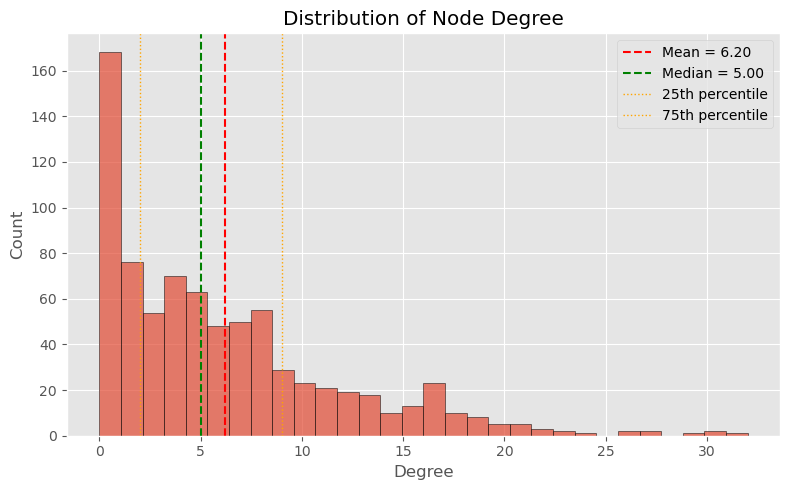

In [54]:
# Degree distribution of original graph

plt.style.use("ggplot")

degree_vals = [deg for _, deg in G.degree()]

mean_deg = np.mean(degree_vals)
median_deg = np.median(degree_vals)
var_deg = np.var(degree_vals)
p25 = np.percentile(degree_vals, 25)
p75 = np.percentile(degree_vals, 75)
min = np.min(degree_vals)
max = np.max(degree_vals)

plt.figure(figsize=(8,5))
plt.hist(degree_vals, bins=30, edgecolor='black', alpha=0.7)

plt.axvline(mean_deg, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {mean_deg:.2f}")
plt.axvline(median_deg, color='green', linestyle='dashed', linewidth=1.5, label=f"Median = {median_deg:.2f}")
plt.axvline(p25, color='orange', linestyle='dotted', linewidth=1, label='25th percentile')
plt.axvline(p75, color='orange', linestyle='dotted', linewidth=1, label='75th percentile')

plt.title("Distribution of Node Degree")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

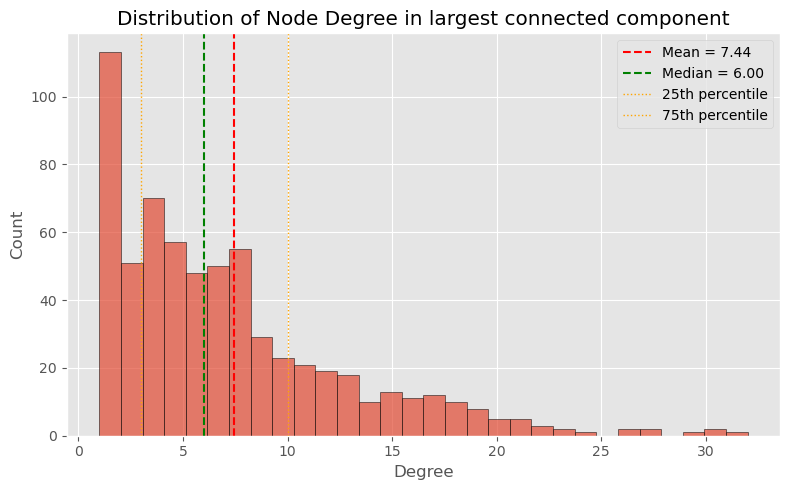

In [46]:
# Degree distribution of largest component

plt.style.use("ggplot")

degree_vals = [deg for _, deg in G_largest.degree()]

mean_deg = np.mean(degree_vals)
median_deg = np.median(degree_vals)
var_deg = np.var(degree_vals)
p25 = np.percentile(degree_vals, 25)
p75 = np.percentile(degree_vals, 75)
min = np.min(degree_vals)
max = np.max(degree_vals)

plt.figure(figsize=(8,5))
plt.hist(degree_vals, bins=30, edgecolor='black', alpha=0.7)

plt.axvline(mean_deg, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {mean_deg:.2f}")
plt.axvline(median_deg, color='green', linestyle='dashed', linewidth=1.5, label=f"Median = {median_deg:.2f}")
plt.axvline(p25, color='orange', linestyle='dotted', linewidth=1, label='25th percentile')
plt.axvline(p75, color='orange', linestyle='dotted', linewidth=1, label='75th percentile')

plt.title("Distribution of Node Degree in largest connected component")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

## Plotting the network

Plot of the network without isolated nodes. 

Color of the nodes shows the release year and size reflects the node degree.

Movietitle added to 50 random nodes.

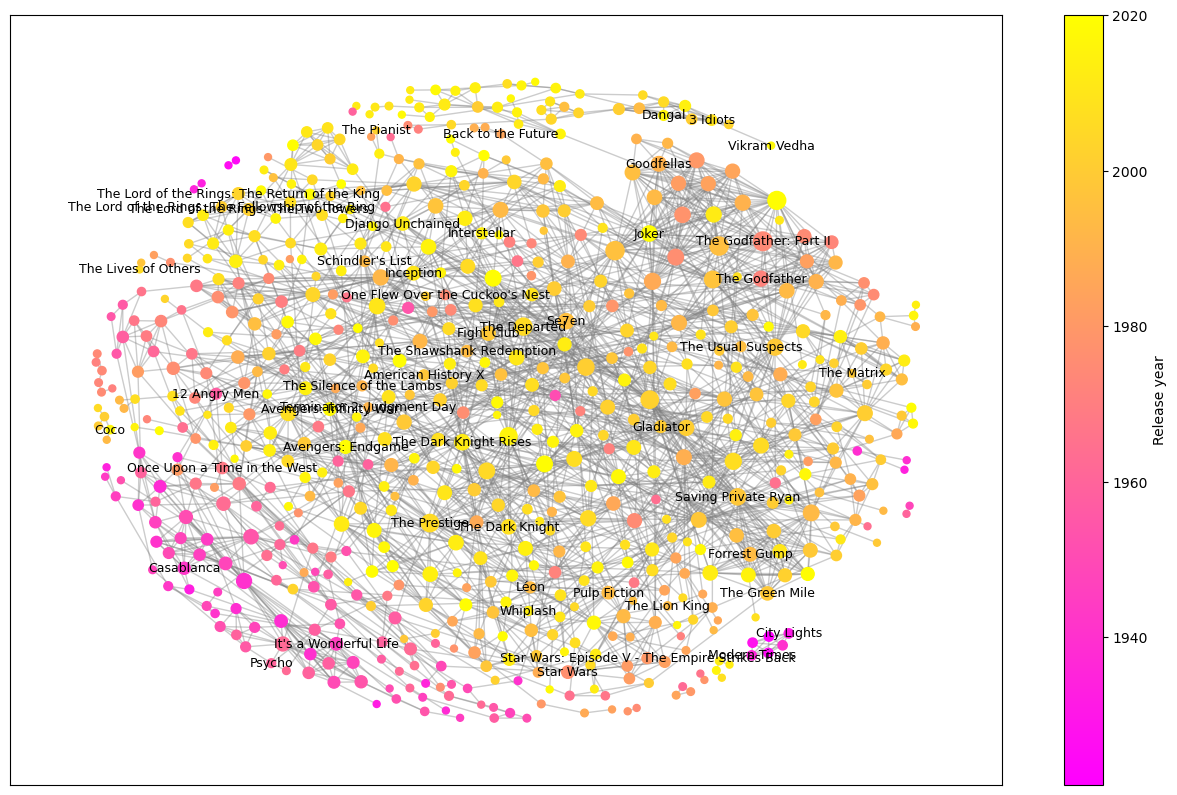

In [44]:
plt.style.use('default')

# # Find node size
degrees = dict(G_no_isolates.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G, "release_year")
node_colors = [release_year.get(n, 0) for n in G_no_isolates.nodes()]

pos = nx.forceatlas2_layout(G_no_isolates, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_no_isolates, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_no_isolates, pos, edge_color="gray", alpha=0.4)


random_nodes = list(degrees.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_no_isolates, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

## Community analysis

### Louvain communities

In [47]:
louv_comm = louvain_communities(G_largest, seed=42)
print(f"Number of communities: {len(louv_comm)}")

M_louvain = nx.community.modularity(G_largest, louv_comm)
print(f"Modularity (Louvain communities): {M_louvain:.4f}")

Number of communities: 16
Modularity (Louvain communities): 0.6764


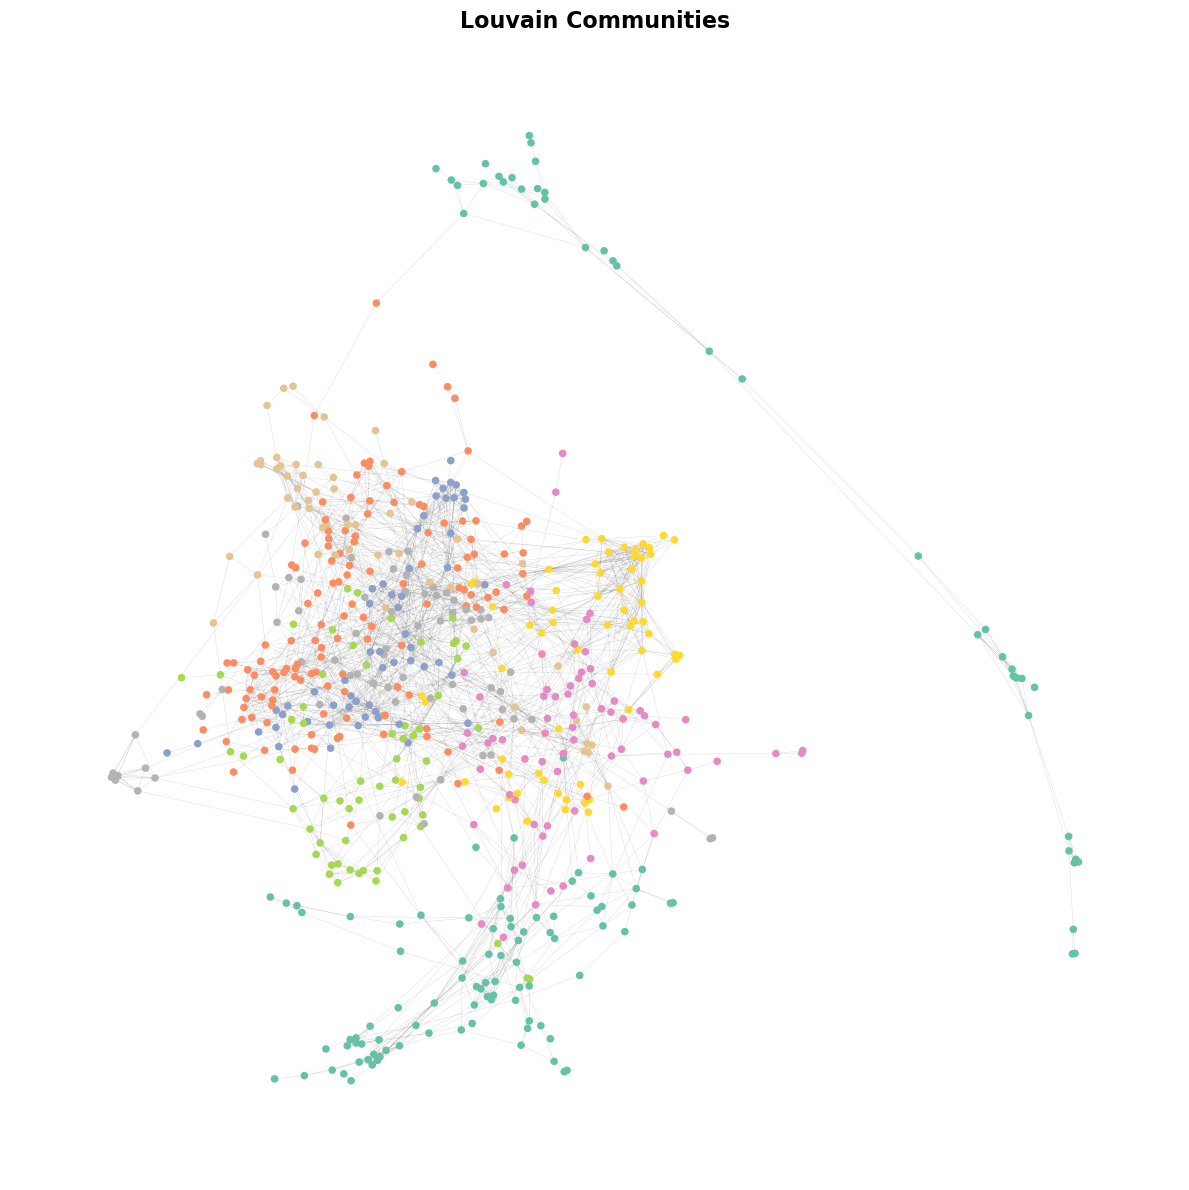

In [53]:
pos = nx.forceatlas2_layout(G, gravity=1.0, seed=100)

top_nodes = set().union(*louv_comm)

# Coloring
colors = plt.cm.Set2(np.linspace(0, 1, len(louv_comm)))
color_map = {}
for i, comm in enumerate(louv_comm):
    for node in comm:
        color_map[node] = colors[i]

node_colors = [color_map.get(n, (0.8, 0.8, 0.8, 0.25)) for n in G_largest.nodes()]

# Plot
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G_largest, pos, alpha=0.15, width=0.3, edge_color="black")
nx.draw_networkx_nodes(
    G_largest,
    pos,
    node_size=30,
    node_color=node_colors,
    linewidths=0.1,
    edgecolors="none",
)
plt.title("Louvain Communities", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()